<a href="https://colab.research.google.com/github/theresiasns/capstone/blob/main/Paddy_Disease_91%2C67_accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install --upgrade tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install keras-preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split

In [5]:
from google.colab import drive
import os

drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
base_dir="/content/drive/MyDrive/dataset/"
!ls"/content/drive/MyDrive/dataset/"

/bin/bash: ls/content/drive/MyDrive/dataset/: No such file or directory


In [7]:
directory =os.path.join(base_dir,"disease/")

In [8]:
Name=[]
for file in os.listdir(directory):
    Name+=[file]
print(Name)
print(len(Name))

['blast', 'blight', 'tungro']
3


In [9]:
N=[]
for i in range(len(Name)):
    N+=[i]
    
normal_mapping=dict(zip(Name,N)) 
reverse_mapping=dict(zip(N,Name)) 

def mapper(value):
    return reverse_mapping[value]

In [10]:
dataset=[]
testset=[]
count=0
for name in Name:
    path=os.path.join(directory,name)
    t=0
    for im in os.listdir(path):
        if im[-4:]=='.jpg':
            image=load_img(os.path.join(path,im), grayscale=False, color_mode='rgb', target_size=(100,100))
            image=img_to_array(image)
            image=image/255.0
            if t<60:
                dataset.append([image,count])
            else:   
                testset.append([image,count])
            t+=1
    count=count+1

In [11]:
data,labels0=zip(*dataset)
test,tlabels0=zip(*testset)

In [12]:
labels1=to_categorical(labels0)
data=np.array(data)
labels=np.array(labels1)

In [13]:
tlabels1=to_categorical(tlabels0)
test=np.array(test)
tlabels=np.array(tlabels1)

In [14]:
print(len(labels))
print(len(tlabels))

180
60


In [15]:
trainx,testx,trainy,testy=train_test_split(data,labels,test_size=0.2,random_state=44)

In [16]:
print(trainx.shape)
print(testx.shape)
print(trainy.shape)
print(testy.shape)

(144, 100, 100, 3)
(36, 100, 100, 3)
(144, 3)
(36, 3)


In [17]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20, #image rotation range
    width_shift_range=0.2, #horizontal shift range
    height_shift_range=0.2, #vertical shift range
    shear_range=0.1,
    zoom_range=[0.2, 3.0],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest") #pixel filling mode for empty areas

In [18]:
# Load the pre-trained model without the top (classification) layers
pretrained_model = tf.keras.applications.DenseNet201(weights='imagenet', input_shape=(100,100,3),include_top=False,pooling='avg')

# Freeze the pre-trained layers so they are not updated during training
for layer in pretrained_model.layers:
  layer.trainable = False

In [20]:
from tensorflow.keras import layers
from keras.layers import Flatten

inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dropout(0.2)(x)  # Dropout layer dengan dropout rate 0.2
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

# Create the fine-tuned model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [21]:
# Compile the model
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [22]:
his=model.fit(datagen.flow(trainx,trainy,batch_size=32),validation_data=(testx,testy),epochs=30)

Epoch 1/30
5/5 [==============================] - 25s 2s/step - loss: 1.9836 - accuracy: 0.3681 - val_loss: 0.7345 - val_accuracy: 0.6389
Epoch 2/30
5/5 [==============================] - 1s 111ms/step - loss: 1.0600 - accuracy: 0.5208 - val_loss: 0.5273 - val_accuracy: 0.8056
Epoch 3/30
5/5 [==============================] - 1s 112ms/step - loss: 0.6987 - accuracy: 0.6875 - val_loss: 0.4224 - val_accuracy: 0.8611
Epoch 4/30
5/5 [==============================] - 1s 122ms/step - loss: 0.6850 - accuracy: 0.7569 - val_loss: 0.2708 - val_accuracy: 0.9722
Epoch 5/30
5/5 [==============================] - 1s 137ms/step - loss: 0.6338 - accuracy: 0.7708 - val_loss: 0.4812 - val_accuracy: 0.7778
Epoch 6/30
5/5 [==============================] - 1s 114ms/step - loss: 0.6193 - accuracy: 0.7292 - val_loss: 0.2477 - val_accuracy: 0.9167
Epoch 7/30
5/5 [==============================] - 1s 114ms/step - loss: 0.5423 - accuracy: 0.7778 - val_loss: 0.2167 - val_accuracy: 0.9722
Epoch 8/30
5/5 [======

In [23]:
y_pred=model.predict(testx)
pred=np.argmax(y_pred,axis=1)
ground = np.argmax(testy,axis=1)
print(classification_report(ground,pred))

2/2 [==============================] - 5s 63ms/step
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        15
           1       1.00      0.92      0.96        13
           2       1.00      0.88      0.93         8

    accuracy                           0.94        36
   macro avg       0.96      0.93      0.94        36
weighted avg       0.95      0.94      0.94        36



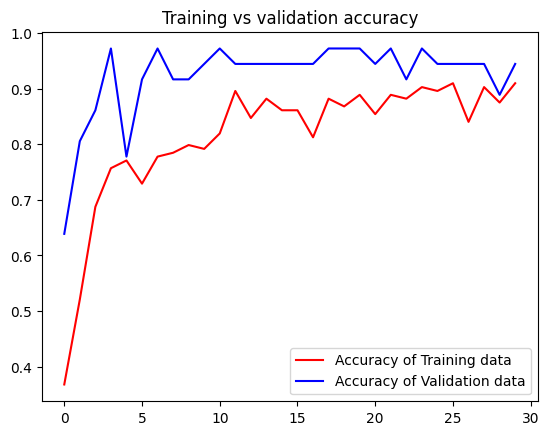

<Figure size 640x480 with 0 Axes>

In [24]:
get_acc = his.history['accuracy']
value_acc = his.history['val_accuracy']
get_loss = his.history['loss']
validation_loss = his.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

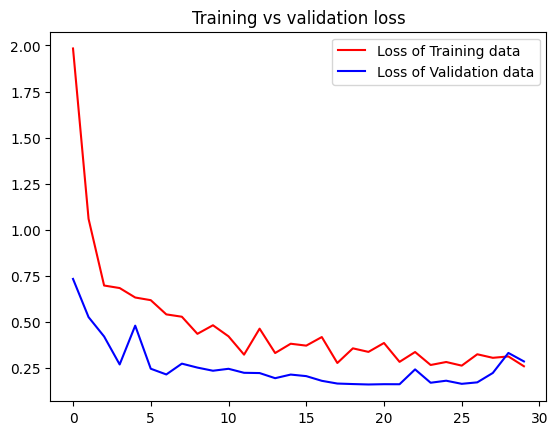

<Figure size 640x480 with 0 Axes>

In [25]:
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

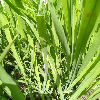

In [26]:
load_img("/content/drive/MyDrive/dataset/paddy-doctor/train_image/hispa/100003.jpg",target_size=(100,100))

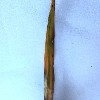

In [27]:
load_img("/content/drive/MyDrive/dataset/disease/tungro/IMG_1028.jpg",target_size=(100,100))

In [28]:
image=load_img("/content/drive/MyDrive/dataset/disease/tungro/IMG_1028.jpg",target_size=(100,100))

image=img_to_array(image) 
image=image/255.0
prediction_image=np.array(image)
prediction_image= np.expand_dims(image, axis=0)

In [29]:
image=load_img("/content/drive/MyDrive/dataset/paddy-doctor/train_image/hispa/100003.jpg",target_size=(100,100))

image=img_to_array(image) 
image=image/255.0
prediction_image=np.array(image)
prediction_image= np.expand_dims(image, axis=0)

In [39]:
## NOTE: If you are using Safari and this cell throws an error,
## please skip this block and run the next one instead.

import numpy as np

from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=load_img(path, target_size=(150, 150))
  
  x=img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=10)

  print(classes[0])
  value=np.argmax(classes)
  move_name=mapper(value)
  
  print("Prediction is {}.".format(move_name))
 

Saving blight3.jpg to blight3.jpg
1/1 [==============================] - 0s 36ms/step
[0.04427351 0.86068696 0.09503955]
Prediction is blight.


In [31]:
print(test.shape)
prediction2=model.predict(test)
print(prediction2.shape)

PRED=[]
for item in prediction2:
    value2=np.argmax(item)      
    PRED+=[value2]

(60, 100, 100, 3)
2/2 [==============================] - 2s 2s/step
(60, 3)


In [32]:
ANS=tlabels0

In [33]:
accuracy=accuracy_score(ANS,PRED)
print(accuracy)

0.9166666666666666
